In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np

In [11]:
x_train = pd.read_csv("X_train.csv", index_col=0)
x_train.head(10)

,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786
5,Afrique Contemporaine N° 212 Hiver 2004 - Doss...,NaN,5862738,393356830
6,Christof E: Bildungsprozessen Auf Der Spur,NaN,91920807,907794536
7,Conquérant Sept Cahier Couverture Polypro 240 ...,CONQUERANT CLASSIQUE Cahier 240 x 320 mm seyès...,344240059,999581347
8,Puzzle Scooby-Doo Avec Poster 2x35 Pieces,NaN,4239126071,1325918866
9,Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - ...,Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m5...,3793572222,1245644185


In [7]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


In [10]:
x_train.isnull().mean()

designation    0.000000
description    0.350935
productid      0.000000
imageid        0.000000
dtype: float64

In [12]:
y_train = pd.read_csv("y_train.csv", index_col=0)
y_train.head()

,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705


In [5]:
print(y_train.nunique())
y_train.value_counts(normalize=True)*100

prdtypecode    27
dtype: int64


prdtypecode
2583           12.022469
1560            5.974139
1300            5.941165
2060            5.879928
2522            5.875218
1280            5.735079
2403            5.622026
2280            5.605540
1920            5.067361
1160            4.655189
1320            3.816713
10              3.669509
2705            3.251448
1140            3.145461
2582            3.048895
40              2.953507
2585            2.939375
1302            2.933487
1281            2.437703
50              1.979603
2462            1.673418
2905            1.026897
60              0.979792
2220            0.970371
1301            0.950351
1940            0.945640
1180            0.899713
Name: proportion, dtype: float64

In [26]:
x_train.nunique()*100/len(x_train)


designation     96.878091
description     55.944698
productid      100.000000
imageid        100.000000
dtype: float64

In [ ]:
# Image paths
input_dir = "images/image_train"
output_dir = "images/image_train_zoomed"
os.makedirs(output_dir, exist_ok=True)

# This will store content ratios for each image
ratios = []

# Process each row in x_train
for _, row in x_train.iterrows():
    image_id = row['imageid']
    product_id = row['productid']
    filename = f"image_{image_id}_product_{product_id}.jpg"
    
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    img = cv2.imread(input_path)

    if img is None:
        print(f"⚠️ Image not found: {input_path}")
        ratios.append(np.nan)
        continue

    h, w = img.shape[:2]

    # Convert to grayscale and threshold to find content
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    # Find contours (the actual content)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print(f"⚠️ No content found: {filename}")
        ratios.append(0.0)
        cv2.imwrite(output_path, img)  # save original
        continue

    # Get bounding box around content
    x, y, w_box, h_box = cv2.boundingRect(np.concatenate(contours))
    
    # Crop to bounding box
    cropped = img[y:y+h_box, x:x+w_box]

    # Calculate actual content ratio
    content_area = w_box * h_box
    original_area = w * h
    ratio = content_area / original_area
    ratios.append(ratio)

    border_size = 10  
    final_size = 224
    target_size = final_size - (2*border_size)

    # Step 1: Resize cropped image while preserving aspect ratio
    scale = min(target_size / w_box, target_size / h_box)
    new_w = int(w_box * scale)
    new_h = int(h_box * scale)
    resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Step 2: Pad to target size
    pad_top = (target_size - new_h) // 2
    pad_bottom = target_size - new_h - pad_top
    pad_left = (target_size - new_w) // 2
    pad_right = target_size - new_w - pad_left


    padded = cv2.copyMakeBorder(resized, pad_top+border_size , pad_bottom+border_size , pad_left+border_size , pad_right+border_size ,
                            borderType=cv2.BORDER_CONSTANT, value=[255, 255, 255])
    

    # Save processed image
    cv2.imwrite(output_path, padded)

# Add ratio column to x_train
x_train["content_ratio"] = ratios

⚠️ No content found: image_1142089742_product_884747735.jpg
⚠️ No content found: image_1302249863_product_3793782107.jpg
⚠️ No content found: image_1137819811_product_1892606336.jpg
⚠️ No content found: image_1271791205_product_3894592691.jpg


In [32]:
img0 = cv2.imread("images/image_train_zoomed/image_1302249863_product_3793782107.jpg")
img0.shape

(500, 500, 3)

In [30]:
folder = "images/image_train_zoomed"
sizes = set()

for filename in os.listdir(folder):
    if filename.endswith(".jpg"):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            sizes.add(img.shape)  # (height, width)

print("Unique image sizes found:", sizes)

Unique image sizes found: {(500, 500, 3), (224, 224, 3)}


In [34]:
x_train.head()

,designation,description,productid,imageid,content_ratio
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,0.118976
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,0.188640
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,0.505352
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,0.512820
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,0.219128


In [20]:
x_train.to_csv("x_train_with_ratios.csv", index=False)

In [36]:
y_train.head()

,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705


In [37]:
df = x_train.join(y_train["prdtypecode"])

In [38]:
avg_ratios = df.groupby("prdtypecode")["content_ratio"].mean().sort_values(ascending=False)
print(avg_ratios)

prdtypecode
2060    0.774212
1920    0.763424
1280    0.680698
2403    0.676582
1300    0.665885
60      0.662748
2582    0.660743
2462    0.660121
1560    0.656982
1302    0.649819
1281    0.638812
1320    0.611704
2220    0.608052
2585    0.607511
1160    0.600565
1180    0.592028
50      0.591647
1301    0.580352
10      0.573373
40      0.568241
2280    0.562701
1140    0.545573
2583    0.511582
1940    0.508613
2522    0.502777
2905    0.369714
2705    0.359793
Name: content_ratio, dtype: float64


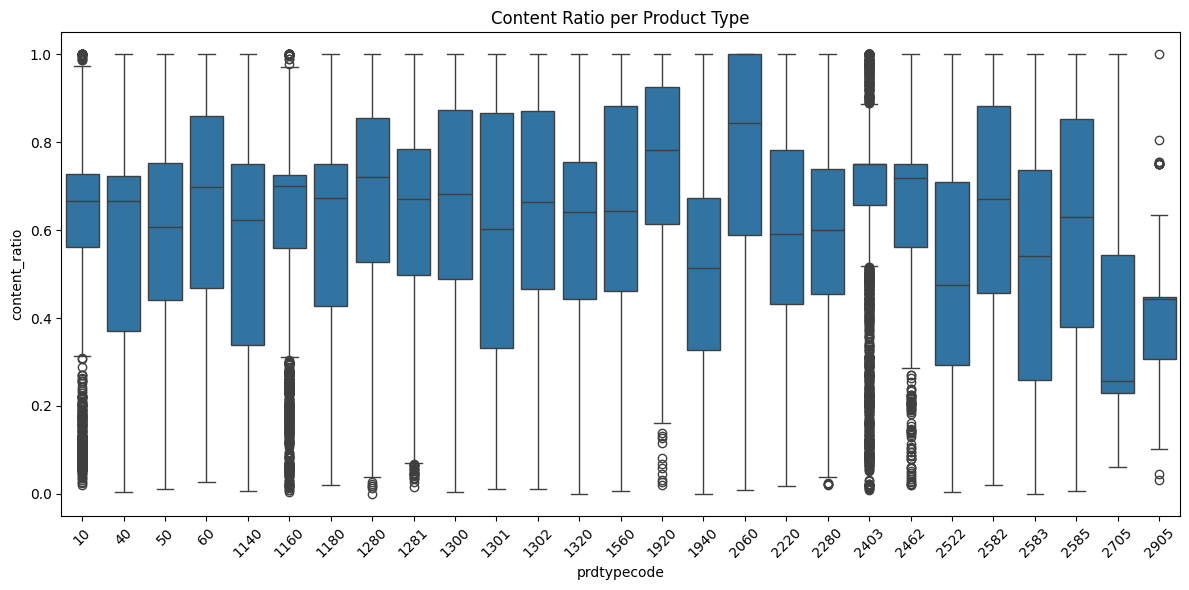

In [ ]:


plt.figure(figsize=(12, 6))
sns.boxplot(x="prdtypecode", y="content_ratio", data=df)
plt.title("Content Ratio per Product Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

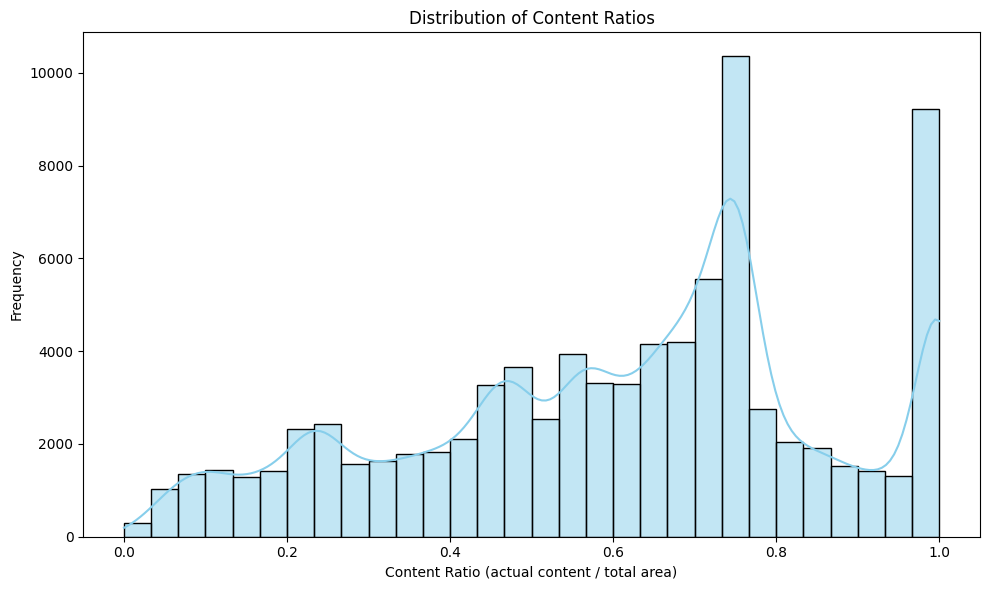

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(df["content_ratio"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Content Ratios")
plt.xlabel("Content Ratio (actual content / total area)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

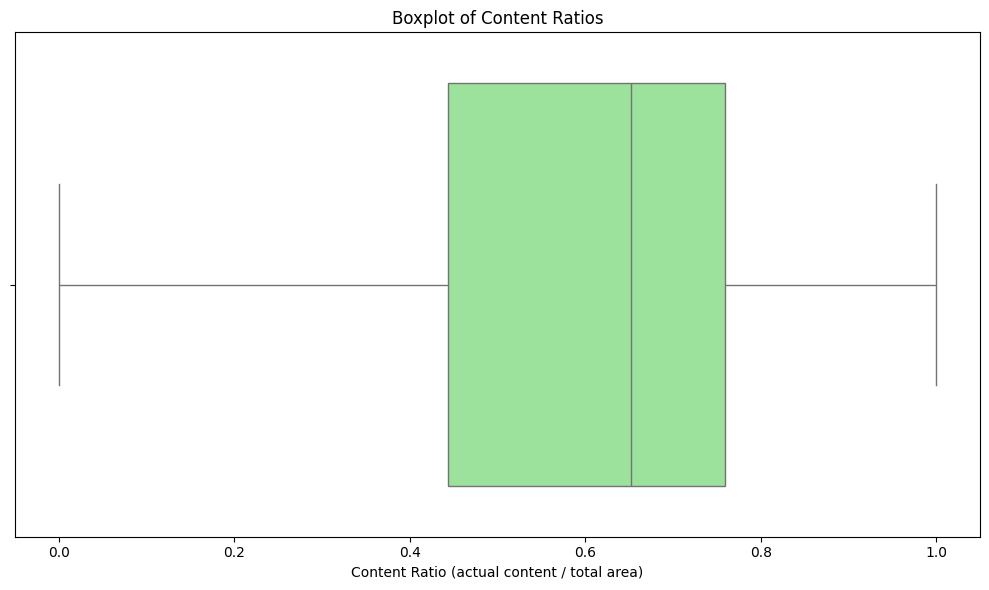

In [50]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["content_ratio"], color="lightgreen")
plt.title("Boxplot of Content Ratios")
plt.xlabel("Content Ratio (actual content / total area)")
plt.tight_layout()
plt.show()

In [43]:
# IQR method on all images
q1 = df["content_ratio"].quantile(0.25)
q3 = df["content_ratio"].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# Filter outliers
overall_outliers = df[(df["content_ratio"] < lower) | (df["content_ratio"] > upper)]
print(f"\n🔍 Found {len(overall_outliers)} outlier images in the dataset.")

# Check which product types they belong to
outlier_counts = overall_outliers["prdtypecode"].value_counts()
print("\n📊 Outlier counts per product type:\n", outlier_counts)


🔍 Found 0 outlier images in the dataset.

📊 Outlier counts per product type:
 Series([], Name: count, dtype: int64)


In [51]:
q1

np.float64(0.44321699999999997)

In [49]:
df.sort_values(by="content_ratio", ascending=True).head(10)

,designation,description,productid,imageid,content_ratio,prdtypecode
52327,Minions Peluche Electronique 25 Cm - Stuart,MINIONS - Retrouve l&#39;univers drôle et déja...,3793782107,1302249863,0.000000,1280
79708,Blagdon extract of barley straw treatment (siz...,NaN,1892606336,1137819811,0.000000,2583
37124,Römer Britax Kid Ii Cosmos Black - Siège Auto,Römer Britax KID II Cosmos Black - Siège Auto,884747735,1142089742,0.000000,1320
80859,Bledina Mini Lactes Nature Sans Sucre - 6 X 55g,BLEDINA Mini lactes nature sans sucre - 6 x 55...,3894592691,1271791205,0.000000,1940
80986,Lait Fluide Corps Hydratant 24h,NaN,505482367,1017262919,0.002208,1320
43750,Space Shuttle - Commodore 64,NaN,1507197387,1086028632,0.003224,40
41816,Kit de nettoyage manuel,Kit de nettoyage manuel comprenant: <br />Epui...,541874293,1032419657,0.004216,2583
80253,Ruban Étiquette Dymo- Nylon Jaune 12 Mm,ruban consommable pour étiqueteuse Dymo ILP219...,49177953,363973030,0.004352,2522
49704,Vis À Bois À Tête Fraisée (Mä 7599),<UL><LI>Classe d'âge : à partir de 15 ans</LI>...,418193051,1005828507,0.004680,1300
29009,Yu-Gi-Oh! Usine Des 100 Machines (Csoc-Fr049),NaN,103081028,868959417,0.005220,1160


In [52]:
df["content_ratio"].quantile(0.25)

np.float64(0.44321699999999997)

In [63]:
lim = 0.2
product_stats = []
for product_type, group in df.groupby("prdtypecode"):
    # 1. Calculate the percentage of rows for that product type
    product_percentage = len(group) / len(df) * 100
    
    # 2. Calculate the average content ratio for that product type
    avg_content_ratio = group["content_ratio"].mean()
    
    # 3. Calculate the ratio of images with content ratios lower than Q1
    #low_ratio_count = (group["content_ratio"] < q1).sum()
    #low_ratio_percentage = low_ratio_count / len(group) * 100
    low_ratio_percentage = (group["content_ratio"] < lim).mean()
    # Add the calculated values to the product_stats list
    product_stats.append([product_type, product_percentage, avg_content_ratio, low_ratio_percentage])

column_name = f"Low Ratio Percentage (<{lim})"
# Convert the results to a DataFrame
stats_df = pd.DataFrame(product_stats, columns=["Product Type", "% of Total Products", "Avg Content Ratio", column_name])

# Display the resulting table
stats_df

,Product Type,% of Total Products,Avg Content Ratio,Low Ratio Percentage (<0.2)
0,10,3.669509,0.573373,0.184531
1,40,2.953507,0.568241,0.124003
2,50,1.979603,0.591647,0.075550
3,60,0.979792,0.662748,0.046875
4,1140,3.145461,0.545573,0.147885
5,1160,4.655189,0.600565,0.073362
6,1180,0.899713,0.592028,0.094241
7,1280,5.735079,0.680698,0.029979
8,1281,2.437703,0.638812,0.057005
9,1300,5.941165,0.665885,0.033102


In [65]:
stats_df.to_csv("product_type_image_statistics.csv", index=False)

In [66]:
print(stats_df.sort_values(by="% of Total Products", ascending=False).to_string(index=False))

 Product Type  % of Total Products  Avg Content Ratio  Low Ratio Percentage (<0.2)
         2583            12.022469           0.511582                     0.169948
         1560             5.974139           0.656982                     0.021683
         1300             5.941165           0.665885                     0.033102
         2060             5.879928           0.774212                     0.021831
         2522             5.875218           0.502777                     0.180196
         1280             5.735079           0.680698                     0.029979
         2403             5.622026           0.676582                     0.036866
         2280             5.605540           0.562701                     0.051681
         1920             5.067361           0.763424                     0.003486
         1160             4.655189           0.600565                     0.073362
         1320             3.816713           0.611704                     0.060784
    

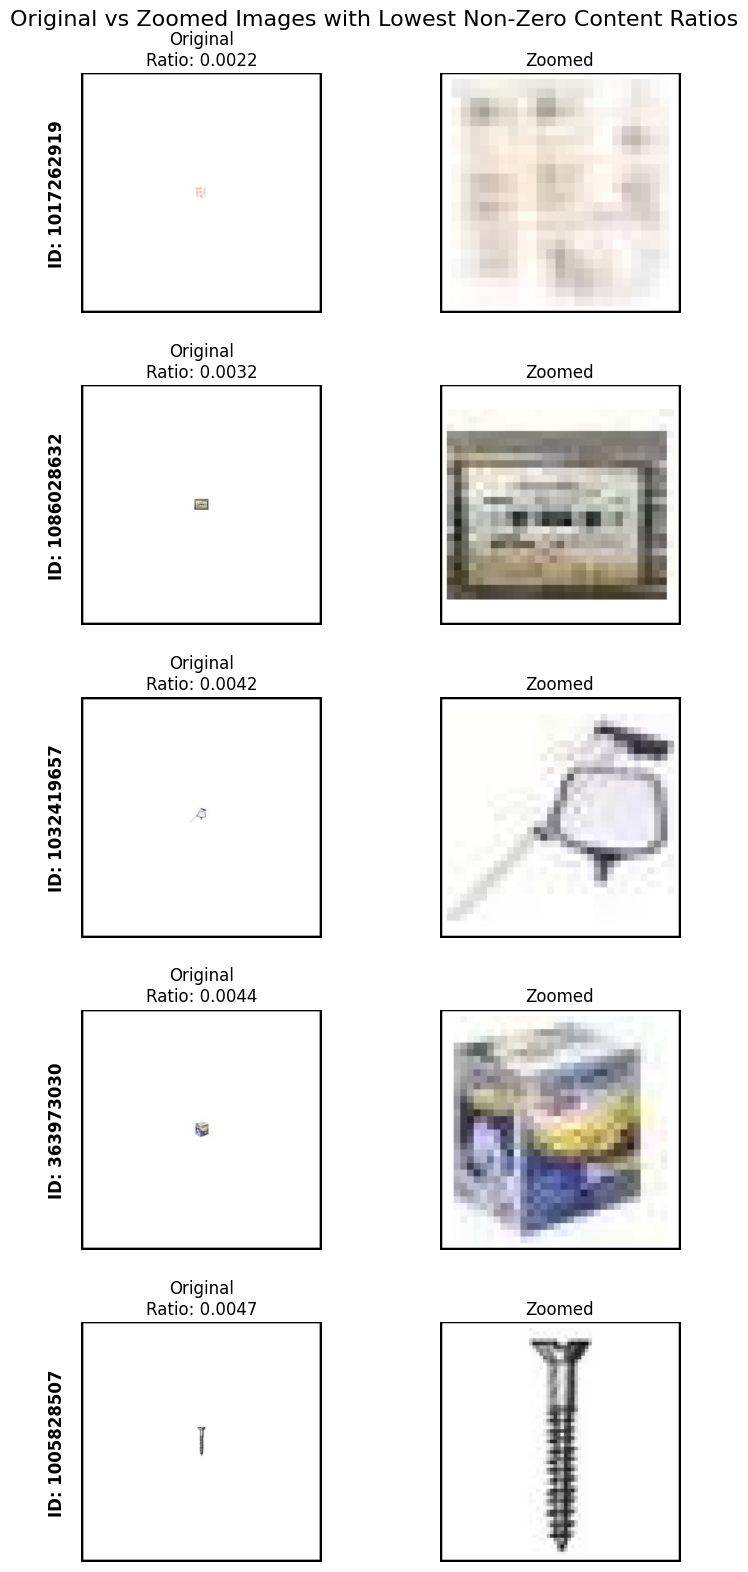

In [84]:
import os

# --- Helper: Add black border around images ---
def add_border(image, border_size=5, color=(0, 0, 0)):
    return cv2.copyMakeBorder(
        image,
        top=border_size,
        bottom=border_size,
        left=border_size,
        right=border_size,
        borderType=cv2.BORDER_CONSTANT,
        value=color
    )

# --- Filter first 5 images with lowest non-zero content ratio ---
nonzero_df = x_train[x_train["content_ratio"] > 0]
sorted_df = nonzero_df.sort_values("content_ratio").head(5)

# --- Plotting ---
fig, axs = plt.subplots(5, 2, figsize=(7, 16))
fig.suptitle("Original vs Zoomed Images with Lowest Non-Zero Content Ratios", fontsize=16)

for i, (_, row) in enumerate(sorted_df.iterrows()):
    imageid = row["imageid"]
    productid = row["productid"]
    filename = f"image_{imageid}_product_{productid}.jpg"

    original_path = os.path.join("images", "image_train", filename)
    zoomed_path = os.path.join("images", "image_train_zoomed", filename)

    # Read images and convert to RGB
    orig = cv2.cvtColor(cv2.imread(original_path), cv2.COLOR_BGR2RGB)
    zoom = cv2.cvtColor(cv2.imread(zoomed_path), cv2.COLOR_BGR2RGB)

    # Add border
    orig = add_border(orig)
    zoom = add_border(zoom)


    # Display original
    axs[i, 0].imshow(orig)
    axs[i, 0].set_title(f"Original\nRatio: {row['content_ratio']:.4f}")
    axs[i, 0].axis('off')
    axs[i, 0].text(-0.1, 0.5, f"ID: {imageid}", ha='center', va='center', rotation=90, 
                   transform=axs[i, 0].transAxes, fontsize=12, color='black', fontweight='bold')

    # Display zoomed
    axs[i, 1].imshow(zoom)
    axs[i, 1].set_title("Zoomed")
    axs[i, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.94, wspace=0.2, hspace=0.3)
plt.show()
plt.show()


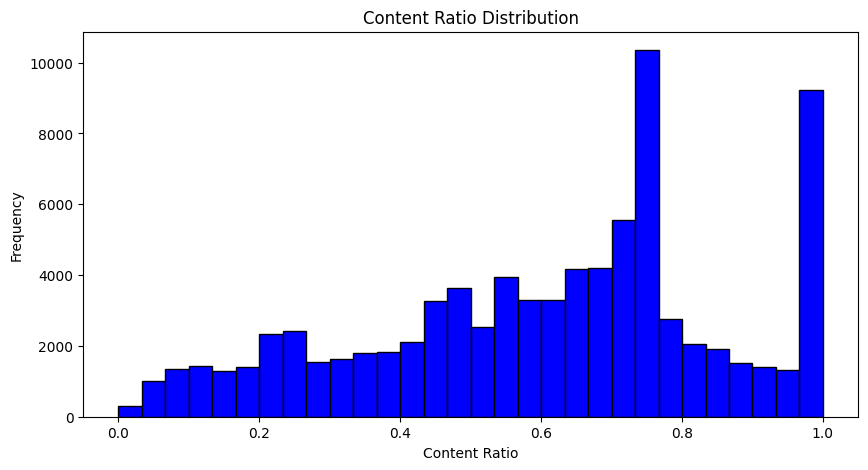

In [82]:
plt.figure(figsize=(10, 5))
plt.hist(x_train["content_ratio"].dropna(), bins=30, color='blue', edgecolor='black')
plt.title("Content Ratio Distribution")
plt.xlabel("Content Ratio")
plt.ylabel("Frequency")
plt.show()

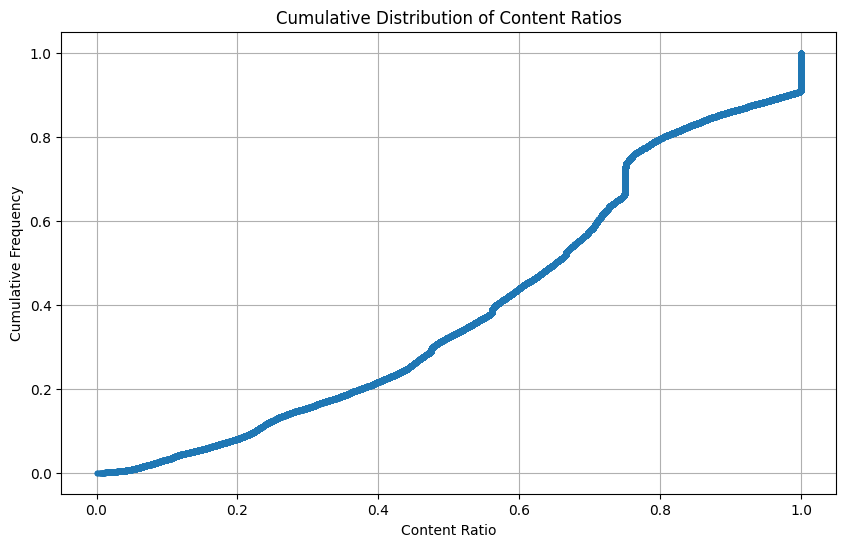

In [85]:
content_ratios = x_train["content_ratio"].dropna().values

# Sort the content ratios
sorted_ratios = np.sort(content_ratios)

# Compute cumulative frequency
cumulative = np.arange(1, len(sorted_ratios) + 1) / len(sorted_ratios)

# Plot the cumulative frequency
plt.figure(figsize=(10, 6))
plt.plot(sorted_ratios, cumulative, marker='.', linestyle='-')
plt.xlabel("Content Ratio")
plt.ylabel("Cumulative Frequency")
plt.title("Cumulative Distribution of Content Ratios")
plt.grid(True)
plt.show()

In [24]:
def plot_random_images_below_threshold(x_train, threshold=0.3, n_images=5, image_dir="images/image_train_zoomed"):
    """
    Plots n random zoomed-in images with content ratio below the given threshold.
    
    Parameters:
        x_train (DataFrame): DataFrame with columns 'imageid', 'productid', and 'content_ratio'.
        threshold (float): Content ratio threshold for filtering images.
        n_images (int): Number of images to display.
        image_dir (str): Directory path where zoomed images are stored.
    """
    # Filter rows with content_ratio below threshold and non-null
    filtered = x_train[(x_train["content_ratio"] < threshold) & (x_train["content_ratio"] > 0.9*threshold) & (x_train["content_ratio"].notnull())]
    
    # Randomly sample images
    if len(filtered) == 0:
        print("⚠️ No images found below the threshold.")
        return
    sampled = filtered.sample(min(n_images, len(filtered)))

    # Plot images
    plt.figure(figsize=(15, 3 * len(sampled)))

    for i, (_, row) in enumerate(sampled.iterrows()):
        image_id = row["imageid"]
        product_id = row["productid"]
        ratio = row["content_ratio"]
        filename = f"image_{image_id}_product_{product_id}.jpg"
        path = os.path.join(image_dir, filename)

        img = cv2.imread(path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, n_images, i + 1)
            plt.imshow(img_rgb)
            plt.title(f"ID: {image_id}\nRatio: {ratio:.3f}")
            plt.axis("off")
        else:
            print(f"⚠️ Could not load {filename}")

    plt.tight_layout()
    plt.show()

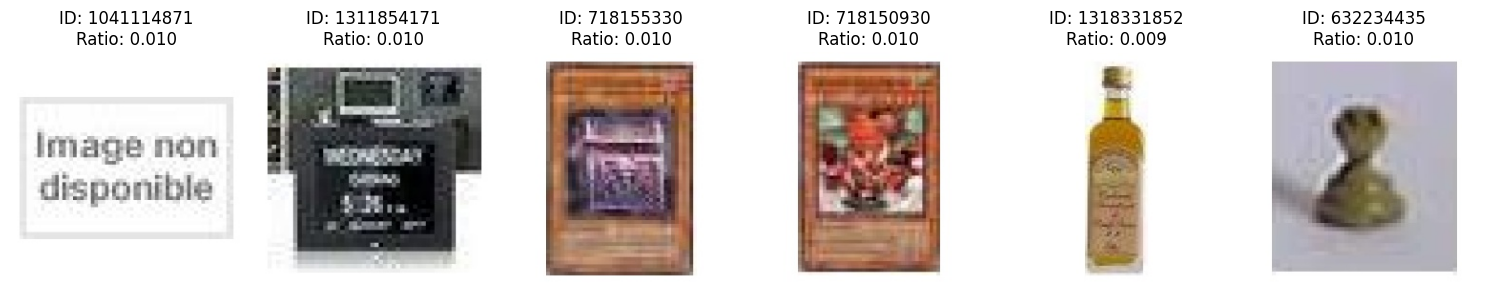

In [25]:
plot_random_images_below_threshold(x_train, threshold=0.01, n_images=6)

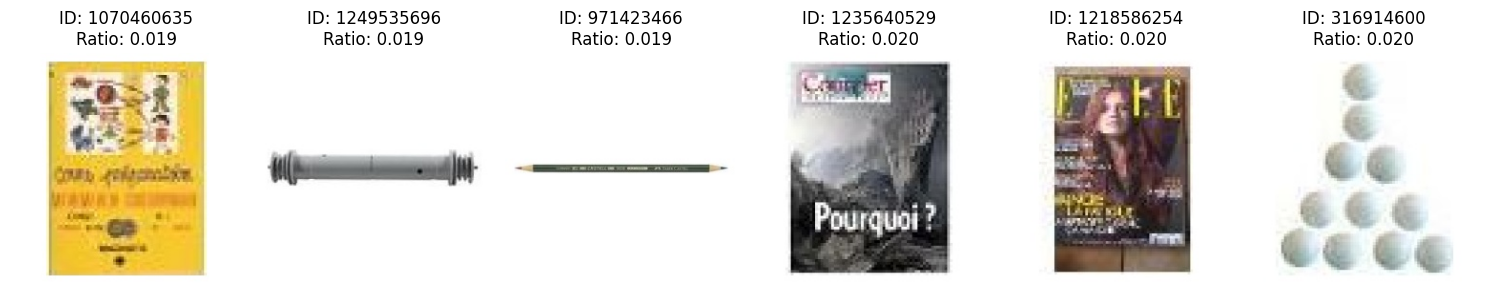

In [26]:
plot_random_images_below_threshold(x_train, threshold=0.02, n_images=6)

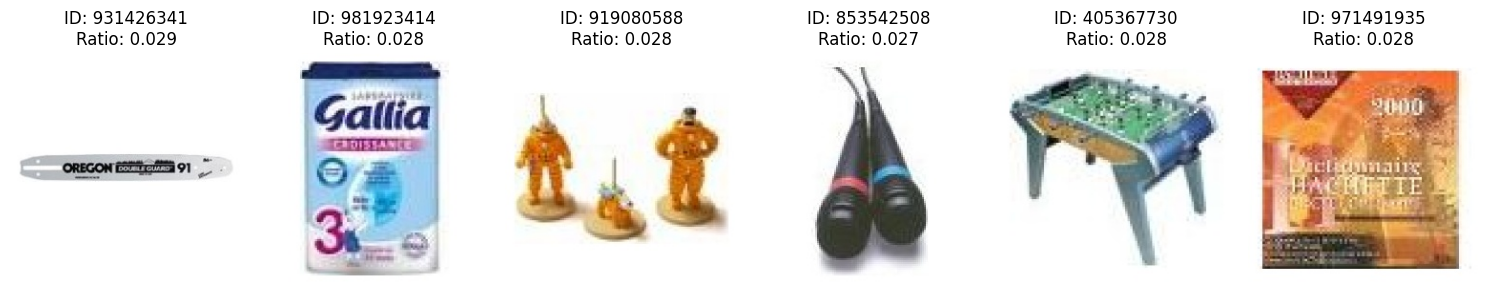

In [27]:
plot_random_images_below_threshold(x_train, threshold=0.03, n_images=6)

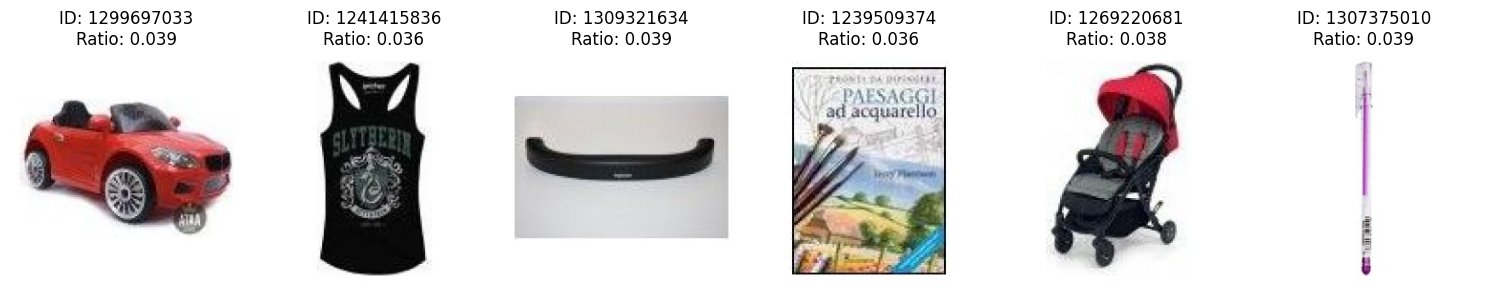

In [28]:
plot_random_images_below_threshold(x_train, threshold=0.04, n_images=6)

In [126]:
display((x_train["content_ratio"] < 0.03).sum())
(x_train["content_ratio"] < 0.03).sum()*100/x_train["content_ratio"].notnull().sum()

np.int64(254)

np.float64(0.2991191294926751)

In [127]:
display((x_train["content_ratio"] < 0.04).sum())
(x_train["content_ratio"] < 0.04).sum()*100/x_train["content_ratio"].notnull().sum()

np.int64(408)

np.float64(0.48047482217721044)

Pick content_ratio >= 0.04 to keep the images

In [ ]:
lim = 0.04
product_stats = []
for product_type, group in df.groupby("prdtypecode"):
    product_percentage = len(group) / len(df) * 100
    avg_content_ratio = group["content_ratio"].mean()
    low_ratio_percentage = (group["content_ratio"] < lim).mean()

    product_stats.append([product_type, product_percentage, avg_content_ratio, low_ratio_percentage])

column_name = f"Low Ratio Percentage (<{lim})"

stats_df = pd.DataFrame(product_stats, columns=["Product Type", "% of Total Products", "Avg Content Ratio", column_name])

stats_df

In [131]:
print(stats_df.sort_values(by="% of Total Products", ascending=False).to_string(index=False))

 Product Type  % of Total Products  Avg Content Ratio  Low Ratio Percentage (<0.04)
         2583            12.022469           0.511582                      0.007249
         1560             5.974139           0.656982                      0.000986
         1300             5.941165           0.665885                      0.001784
         2060             5.879928           0.774212                      0.001001
         2522             5.875218           0.502777                      0.013430
         1280             5.735079           0.680698                      0.001643
         2403             5.622026           0.676582                      0.004189
         2280             5.605540           0.562701                      0.001681
         1920             5.067361           0.763424                      0.000697
         1160             4.655189           0.600565                      0.005312
         1320             3.816713           0.611704                      0

In [ ]:
def plot_original_image(image_id, x_train, image_dir="images/image_train"):
    """
    Plots the original image with the given image_id.
    Parameters:
        image_id (int or str): The image ID to display.
        x_train (DataFrame): DataFrame with 'imageid' and 'productid' fields.
        image_dir (str): Directory where original images are stored.
    """
    row = x_train[x_train["imageid"] == image_id]
    if row.empty:
        print(f"⚠️ No image found in x_train with imageid {image_id}")
        return
    
    product_id = row.iloc[0]["productid"]
    filename = f"image_{image_id}_product_{product_id}.jpg"
    path = os.path.join(image_dir, filename)
    
    img = cv2.imread(path)
    if img is None:
        print(f"⚠️ Image file not found at {path}")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.title(f"Original Image: {filename}")
    plt.axis("off")
    plt.show()

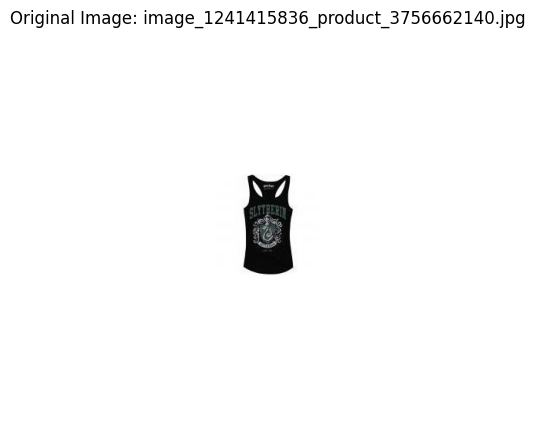

In [133]:
plot_original_image(image_id=1241415836, x_train=x_train)

In [138]:
x_train.head()

,designation,description,productid,imageid,content_ratio
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,0.118976
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,0.188640
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,0.505352
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,0.512820
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,0.219128
